### Focus: The "Uncensored" Truth.

### Imports & Load Data

In [22]:
# Cell 1: Imports & Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# the file paths 
# to be fetched
# RAW_FILE = "../data/EURUSD_H1_Raw.parquet"
# # to be saved
# LABELED_FILE = "../data/EURUSD_H1_Labeled.parquet"


### 2: Data Loading & Resampling Function

In [23]:
import pandas as pd
import numpy as np
import os

def load_and_resample_data(filepath):
    """
    Loads H1 data from Parquet and resamples it to H4.
    """
    # Read Parquet (Preserves Datetime Index automatically)
    df = pd.read_parquet(filepath)

    # Sanity check: ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # We build the aggregation dictionary dynamically based on what columns exist
    agg_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last'
    }
    
    # If 'tick_volume' exists, we SUM it (Volume accumulates over time)
    if 'tick_volume' in df.columns:
        agg_dict['tick_volume'] = 'sum'
    elif 'volume' in df.columns: # Sometimes named just 'volume'
        agg_dict['volume'] = 'sum'

    # If 'spread' exists, we take the MEAN (Average cost over the 4 hours)
    if 'spread' in df.columns:
        agg_dict['spread'] = 'mean'

    df_4h = df.resample('4h').agg(agg_dict)
    
    # Drop any incomplete candles (nans created by resampling gaps)
    df_4h.dropna(inplace=True)
    
    return df_4h


### 3: The Labeling Function (Triple Barrier)

In [24]:

def apply_triple_barrier_labels(df, t_barrier_periods, pt_mult, sl_mult):
    """
    df: The dataframe (already resampled to 4H)
    t_barrier_periods: The number of CANDLES to look ahead
    """
    df = df.copy()

    # 1. Calculate ATR
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = abs(df['high'] - df['close'].shift(1))
    df['l-pc'] = abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=14).mean()

    labels = []
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df)):
        # Safety checks
        if i < 14 or i + t_barrier_periods >= len(df):
            labels.append(np.nan)
            continue
            
        current_close = closes[i]
        current_atr = atrs[i]

        if np.isnan(current_atr):
            labels.append(np.nan)
            continue

        upper_barrier = current_close + (pt_mult * current_atr)
        lower_barrier = current_close - (sl_mult * current_atr)
        end_idx = i + t_barrier_periods
        
        future_highs = highs[i+1 : end_idx+1]
        future_lows = lows[i+1 : end_idx+1]

        outcome = 0 
        hit_both_count = 0
        
        for j in range(len(future_highs)):
            hit_upper = future_highs[j] >= upper_barrier
            hit_lower = future_lows[j] <= lower_barrier

            if hit_upper and hit_lower:
                hit_both_count += 1
                outcome = 0 
                break 
            elif hit_upper:
                outcome = 1 # Buy
                break
            elif hit_lower:
                outcome = -1 # Sell
                break

        labels.append(outcome)
        
    print(f"Ambiguous Events: {hit_both_count} out of {len(df)} candles ({(hit_both_count / len(df)) * 100:.2f}%)")
        
    df['label'] = labels
    return df.dropna()

### Execution & Data Processing

In [25]:
# 1. Load Data
filepath = "../data/EURUSD_H1_Raw.parquet"
df_4h = load_and_resample_data(filepath) 

# 2. Define Parameters
hour_horizons = [8, 12, 16, 20, 24]
pt_multiplier = 1.5
sl_multiplier = 1.5

results = {}

# 3. Process all scenarios
for hours in hour_horizons:
    periods = int(hours / 4)
    print(f"Processing Horizon: {hours} Hours ({periods} candles)...")
    
    labeled_df = apply_triple_barrier_labels(
        df_4h, 
        t_barrier_periods=periods, 
        pt_mult=pt_multiplier, 
        sl_mult=sl_multiplier
    )
    
    results[hours] = labeled_df

print("Processing Complete.")


Processing Horizon: 8 Hours (2 candles)...
Ambiguous Events: 0 out of 9319 candles (0.00%)
Processing Horizon: 12 Hours (3 candles)...
Ambiguous Events: 0 out of 9319 candles (0.00%)
Processing Horizon: 16 Hours (4 candles)...
Ambiguous Events: 0 out of 9319 candles (0.00%)
Processing Horizon: 20 Hours (5 candles)...
Ambiguous Events: 0 out of 9319 candles (0.00%)
Processing Horizon: 24 Hours (6 candles)...
Ambiguous Events: 0 out of 9319 candles (0.00%)
Processing Complete.


### save all the files for each barrier

In [26]:

# 4. Save to Parquet
output_folder = '../data'
os.makedirs(output_folder, exist_ok=True)

print(f"\nSaving files to: {output_folder} ...")

for hours, df in results.items():
    # UPDATED: Filename now uses .parquet extension
    filename = f"triple_barrier_{hours}h.parquet"
    full_path = os.path.join(output_folder, filename)
    
    # UPDATED: Using to_parquet (preserves index automatically)
    df.to_parquet(full_path, index=True)
    
    print(f"Saved: {filename} ({len(df)} rows)")

print("\nAll files saved successfully.")


Saving files to: ../data ...
Saved: triple_barrier_8h.parquet (9303 rows)
Saved: triple_barrier_12h.parquet (9302 rows)
Saved: triple_barrier_16h.parquet (9301 rows)
Saved: triple_barrier_20h.parquet (9300 rows)
Saved: triple_barrier_24h.parquet (9299 rows)

All files saved successfully.


### Visualization (NEW)

Reading files from ../data and plotting last 100 candles...



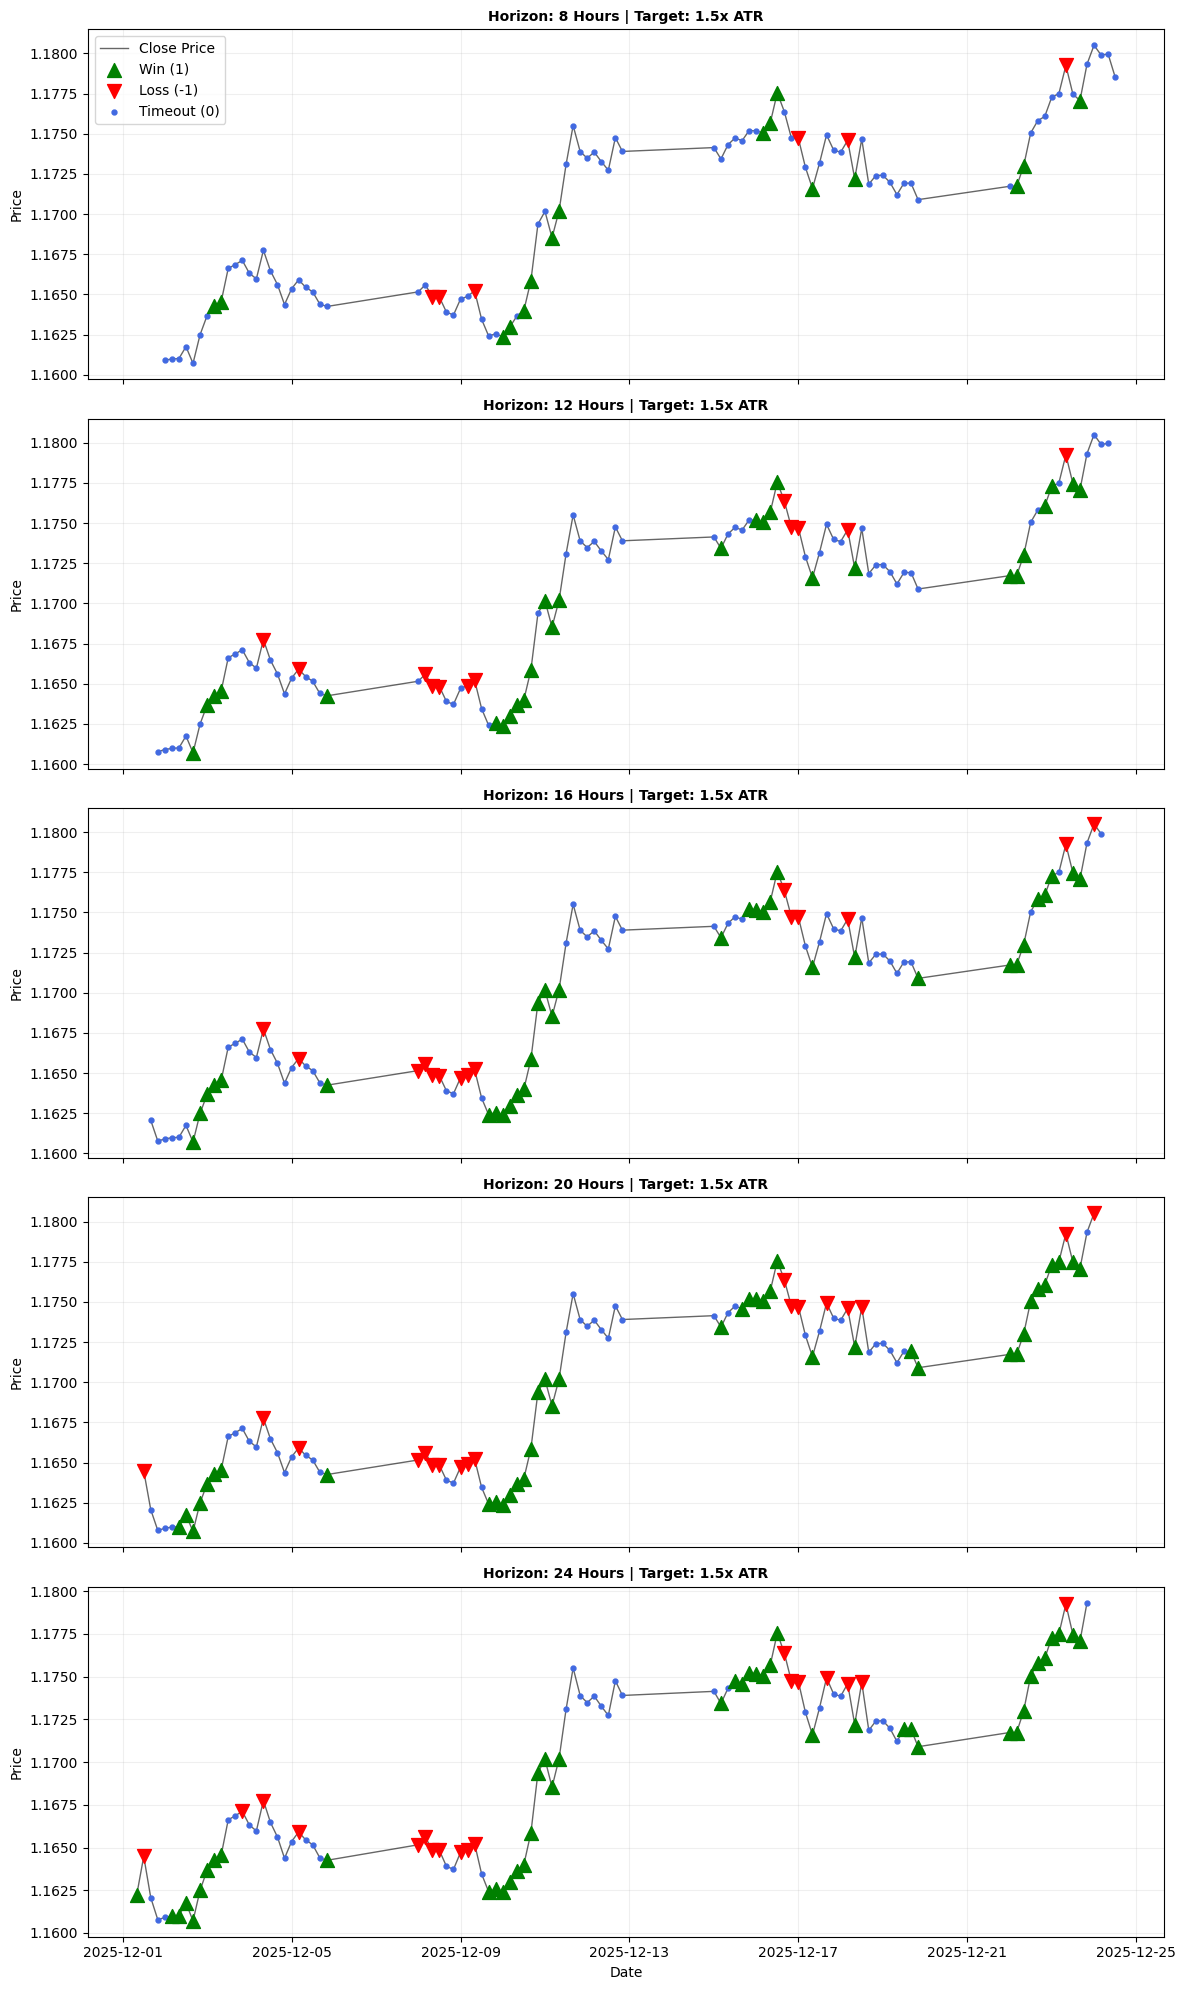

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# 1. Setup
data_folder = '../data'
hour_horizons = [8, 12, 16, 20, 24]
plot_slice = 100
pt_multiplier = 1.5 

fig, axes = plt.subplots(len(hour_horizons), 1, figsize=(12, 20), sharex=True)

print(f"Reading files from {data_folder} and plotting last {plot_slice} candles...\n")

for idx, hours in enumerate(hour_horizons):
    # UPDATED: Look for .parquet file
    filename = f"triple_barrier_{hours}h.parquet"
    filepath = os.path.join(data_folder, filename)
    
    # UPDATED: Read using read_parquet
    df_full = pd.read_parquet(filepath)
    
    # Slice the data for zooming
    df_plot = df_full.iloc[-plot_slice:].copy()
    
    ax = axes[idx]
    
    # Plot Price
    ax.plot(df_plot.index, df_plot['close'], color='black', alpha=0.6, linewidth=1, label='Close Price')
    
    # Filter Outcomes
    wins = df_plot[df_plot['label'] == 1]
    losses = df_plot[df_plot['label'] == -1]
    timeouts = df_plot[df_plot['label'] == 0]
    
    # Plot Markers
    ax.scatter(wins.index, wins['close'], color='green', marker='^', s=100, label='Win (1)', zorder=3)
    ax.scatter(losses.index, losses['close'], color='red', marker='v', s=100, label='Loss (-1)', zorder=3)
    ax.scatter(timeouts.index, timeouts['close'], color='royalblue', marker='.', s=50, label='Timeout (0)', zorder=2)
    
    ax.set_title(f"Horizon: {hours} Hours | Target: {pt_multiplier}x ATR", fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.2)
    ax.set_ylabel("Price")
    
    if idx == 0:
        ax.legend(loc='upper left', frameon=True)

plt.xlabel("Date")
plt.tight_layout()
plt.show()

###  Class Balance Statistics

In [28]:
import pandas as pd
import os

data_folder = '../data'
hour_horizons = [8, 12, 16, 20, 24]

summary_stats = []

for hours in hour_horizons:
    # UPDATED: Look for .parquet file
    filename = f"triple_barrier_{hours}h.parquet"
    filepath = os.path.join(data_folder, filename)
    
    # UPDATED: Read using read_parquet
    df = pd.read_parquet(filepath)
    
    # Count Classes
    counts = df['label'].value_counts(normalize=True) * 100
    
    stats = {
        'Horizon': f"{hours} Hours",
        'Win (1) %': round(counts.get(1.0, 0), 2),
        'Loss (-1) %': round(counts.get(-1.0, 0), 2),
        'Timeout (0) %': round(counts.get(0.0, 0), 2),
        'Total Samples': len(df)
    }
    summary_stats.append(stats)

stats_df = pd.DataFrame(summary_stats)
print("--- Class Balance Distribution ---")
stats_df

--- Class Balance Distribution ---


,Horizon,Win (1) %,Loss (-1) %,Timeout (0) %,Total Samples
0,8 Hours,12.01,12.31,75.69,9303
1,12 Hours,18.60,18.80,62.60,9302
2,16 Hours,24.45,24.59,50.96,9301
3,20 Hours,29.71,29.94,40.35,9300
4,24 Hours,33.62,33.86,32.52,9299
